In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

import math
import pandas as pd
import numpy as np


# import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [6]:
df = pd.read_excel("forecast_data20242-025.xlsx", header=2)
df.head()
#easier column classification
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df.rename( columns= {"InvoiceDate": "date" ,
                          "Customer Name": "cust_id",
                          "QtyInvoiced": "qty",
                          "Unit": "price",
                          "SKU": "item",
                          "Region2": "region",
                          "Colour": "color",
                          "Container": "container",
                          "NetSalesValue": "netsales",
                          "PostCurrency": "currency",
                         
                         })

#ensure ints and categories are category
df['item'] = df['item'].astype("category")
df['region'] = df['region'].astype("category")
df['cust_id'] = df['cust_id'].astype("category")
df["color_container"] = (df['color'] + "_" + df["container"]).astype("category")
df['color'] = df['color'].astype("category")
df['container'] = df['container'].astype("category")
df['currency'] = df['currency'].astype("category")
df["qty_sold"] = np.where(df["qty"] >= 0, df["qty"], 0)
df = df.sort_values(by=["item", "date"])

In [7]:
df = df.drop(['TrnYear', 'TrnMonth', 'Register', 'Invoice', 'SummaryLine',
       'DetailLine',  'Branch', 'Cust #', 'Area',
     'SKU Description', 'Warehouse', 'Mass',
       'Volume',  'TaxValue', 'DiscValue', 'LineType',
       'PriceCode', 'DocumentType', 'GlYear', 'GlPeriod', 'SalesOrder',
       'ContractPrcNum', 'LineInvoiceDisc', 'SalesOrderLine',
       'StockUom'], axis=1)

In [8]:
items = df.item.unique()
dates = pd.date_range(df['date'].min(), df['date'].max())
full_idx = pd.MultiIndex.from_product([items, dates], names=["item", "date"])
full_df = pd.DataFrame(index=full_idx).reset_index()
combined_item = df.groupby(["item", "date"]).agg({
    "qty": "sum",
    "price": "mean"
})
df_merged = pd.merge(full_df, df, on=["item","date"], how="left")

# Fill qty_sold = 0 where no sale
df_merged['qty_sold'] = df_merged['qty_sold'].fillna(0)

# Fill price with the catalog price
# Assuming you have a price lookup per item
catalog_price = df.groupby("item")["price"].first().to_dict()
df_merged['price'] = df_merged.apply(
    lambda row: catalog_price[row['item']] if pd.isna(row['price']) else row['price'], axis=1
)

/tmp/ipykernel_490757/4198552683.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_item = df.groupby(["item", "date"]).agg({
/tmp/ipykernel_490757/4198552683.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  catalog_price = df.groupby("item")["price"].first().to_dict()


In [9]:
df = df_merged
df['dayofweek'] = np.sin(2 * np.pi * df['date'].dt.dayofweek/7)
df['month'] = np.sin(2 * np.pi * df['date'].dt.month/12)
df['dayofyear'] = np.sin(2 * np.pi * df['date'].dt.dayofyear/365)
df['day'] = np.sin(2 * np.pi * df['date'].dt.day/30)
df['year'] = df['date'].dt.year
df['quarter'] = df.date.dt.quarter

In [11]:
df

,item,date,cust_id,region,qty,price,netsales,currency,color,container,...,year,quarter,qty_sold_lag1,qty_sold_lag7,qty_sold_lag14,qty_sold_lag30,rolling_mean_3,rolling_std_3,rolling_mean_7,rolling_std_7
0,4750001,2023-07-04,NaN,NaN,NaN,800.0,NaN,NaN,NaN,NaN,...,2023,3,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
1,4750001,2023-07-05,NaN,NaN,NaN,800.0,NaN,NaN,NaN,NaN,...,2023,3,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
2,4750001,2023-07-06,NaN,NaN,NaN,800.0,NaN,NaN,NaN,NaN,...,2023,3,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
3,4750001,2023-07-07,NaN,NaN,NaN,800.0,NaN,NaN,NaN,NaN,...,2023,3,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
4,4750001,2023-07-08,NaN,NaN,NaN,800.0,NaN,NaN,NaN,NaN,...,2023,3,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860300,4751177,2025-06-26,NaN,NaN,NaN,800.0,NaN,NaN,NaN,NaN,...,2025,2,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
860301,4751177,2025-06-27,NaN,NaN,NaN,800.0,NaN,NaN,NaN,NaN,...,2025,2,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
860302,4751177,2025-06-28,NaN,NaN,NaN,800.0,NaN,NaN,NaN,NaN,...,2025,2,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
860303,4751177,2025-06-29,NaN,NaN,NaN,800.0,NaN,NaN,NaN,NaN,...,2025,2,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN


In [12]:
#create lags and rolling
target = "qty_sold"
lags = [1, 7, 14, 30]
for lag_i in lags:
    df[f"{target}_lag{lag_i}"] =  df.groupby(["item", "date"])[target].shift(lag_i).fillna(0)
lag_feats = [ f"{target}_lag{i}" for i in lags]
df.columns

/tmp/ipykernel_490757/884203138.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f"{target}_lag{lag_i}"] =  df.groupby(["item", "date"])[target].shift(lag_i).fillna(0)


Index(['item', 'date', 'cust_id', 'region', 'qty', 'price', 'netsales',
       'currency', 'color', 'container', 'color_container', 'qty_sold',
       'dayofweek', 'month', 'dayofyear', 'day', 'year', 'quarter',
       'qty_sold_lag1', 'qty_sold_lag7', 'qty_sold_lag14', 'qty_sold_lag30',
       'rolling_mean_3', 'rolling_std_3', 'rolling_mean_7', 'rolling_std_7'],
      dtype='object')

In [13]:
lag_feats

['qty_sold_lag1', 'qty_sold_lag7', 'qty_sold_lag14', 'qty_sold_lag30']

In [ ]:
# Example: 2-day rolling mean for each client-item pair

for i in [3, 7, 14, 30]:
    df[f"rolling_mean_{i}"] = (
        df.groupby(["item", "date"])[target]
          .rolling(window=i, min_periods=1)
          .mean()
          .reset_index(level=[0,1], drop=True)
    )
    lag_feats.append(f"rolling_mean_{i}")
    df[f"rolling_std_{i}"] = (
        df.groupby(["item", "date"])[target]
          .rolling(window=i, min_periods=1)
          .std()
          .reset_index(level=[0,1], drop=True)
    )
    
    lag_feats.append(f"rolling_std_{i}")

In [16]:
def split_train_test(df, split_date):
    train = df[df['date'] < split_date].copy()
    test = df[df['date'] >= split_date].copy()
    return (train, test)

def target_feature_split(df, features, target):
    X, y = df[features], df[target]
    return (X, y)
    

In [40]:
# =========================
# 🌿 Tiny LightGBM train
# =========================
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define split date
split_date = '2025-03-01'
target = "qty_sold"

basic_feats = ["item","price","day", "month", "year", "dayofweek", "dayofyear"] + lag_feats
train , test = split_train_test(df, split_date)
train = train.sort_values("date")
test = test.sort_values("date")
X_train, y_train = target_feature_split(train, basic_feats, target)
X_val, y_val = target_feature_split(test, basic_feats, target)

model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=32,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

cat_feats = ['item']
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_feats,
    callbacks=[]
    # early_stopping removed in some LightGBM builds; if available:
    # callbacks=[lightgbm.early_stopping(100), lightgbm.log_evaluation(100)]
)

# Evaluate (RMSLE)
y_val_pred = model.predict(X_val)
# rmsle = root_mean_squared_log_error(y_val, val_pred)
rmse = root_mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
# print(f"Validation RMSLE: {rmsle:.5f}")
print(f"Validation RMSE: {rmse:.5f}")
print(f"Validation MAE: {mae:.5f}")

y_train_pred = model.predict(X_train)
rmse = root_mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Training RMSE: {rmse:.5f}")
print(f"Training MAE: {mae:.5f}")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 716174, number of used features: 9
[LightGBM] [Info] Start training from score 1.316634
Validation RMSE: 2.25651
Validation MAE: 0.10735
Training RMSE: 2.02338
Training MAE: 0.07574


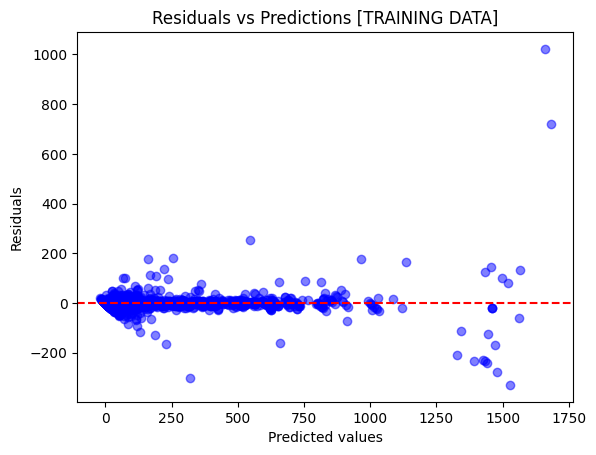

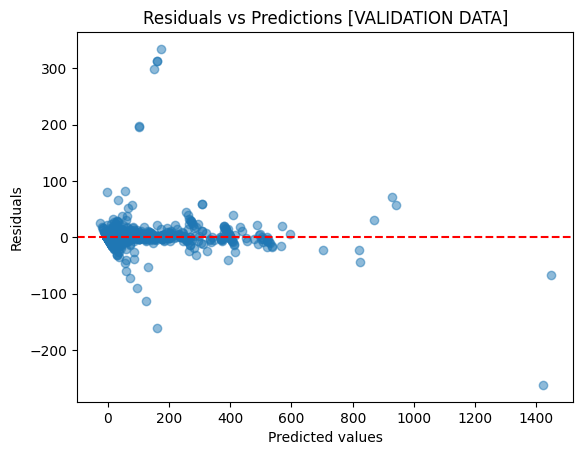

In [32]:
resid_train = y_train - y_train_pred
resid_val = y_val - y_val_pred
import matplotlib.pyplot as plt

plt.scatter(y_train_pred, resid_train, alpha=0.5, c='blue')
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions [TRAINING DATA]")
plt.show()

plt.scatter(y_val_pred, resid_val, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions [VALIDATION DATA]")
plt.show()

In [33]:
test

,item,date,cust_id,region,qty,price,netsales,currency,color,container,...,year,quarter,qty_sold_lag1,qty_sold_lag7,qty_sold_lag14,qty_sold_lag30,rolling_mean_3,rolling_std_3,rolling_mean_7,rolling_std_7
625,4750001,2025-03-01,NaN,NaN,NaN,800.0,NaN,NaN,NaN,NaN,...,2025,1,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
584357,4750800,2025-03-01,NaN,NaN,NaN,400.0,NaN,NaN,NaN,NaN,...,2025,1,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
585090,4750801,2025-03-01,NaN,NaN,NaN,1300.0,NaN,NaN,NaN,NaN,...,2025,1,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
585823,4750802,2025-03-01,NaN,NaN,NaN,1300.0,NaN,NaN,NaN,NaN,...,2025,1,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
586557,4750803,2025-03-01,NaN,NaN,NaN,1300.0,NaN,NaN,NaN,NaN,...,2025,1,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609474,4750833,2025-06-30,NaN,NaN,NaN,900.0,NaN,NaN,NaN,NaN,...,2025,2,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
610202,4750834,2025-06-30,NaN,NaN,NaN,1800.0,NaN,NaN,NaN,NaN,...,2025,2,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
610930,4750835,2025-06-30,NaN,NaN,NaN,1800.0,NaN,NaN,NaN,NaN,...,2025,2,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
600254,4750821,2025-06-30,NaN,NaN,NaN,3800.0,NaN,NaN,NaN,NaN,...,2025,2,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN


In [34]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
import numpy as np

print("TRAINING Heteroscedasticity TEST")
exog = sm.add_constant(y_train_pred)  
bp_test = het_breuschpagan(resid_train, exog)
print("Breusch–Pagan p-value:", bp_test[1])

white_test = het_white(resid_train, exog)
print("White test p-value:", white_test[1])
print("-"*10)
print("VALIDATION Heteroscedasticity TEST")
exog = sm.add_constant(y_val_pred)  
bp_test = het_breuschpagan(resid_val, exog)
print("Breusch–Pagan p-value:", bp_test[1])

white_test = het_white(resid_val, exog)
print("White test p-value:", white_test[1])

TRAINING Heteroscedasticity TEST
Breusch–Pagan p-value: 0.0
White test p-value: 0.0
----------
VALIDATION Heteroscedasticity TEST
Breusch–Pagan p-value: 0.0
White test p-value: 0.0


In [39]:
mask = y_val != 0
predictions = pd.DataFrame({
    "item": test.loc[test['qty_sold'] !=0, 'item'],
    "date": test.loc[test['qty_sold'] !=0, 'date'],
    "y_val": y_val[mask],
    "y_pred": y_val_pred[mask],
    "actual_resid": resid_val[mask],
})
predictions.to_csv("product_demand.csv", index=False)
predictions

,item,date,y_val,y_pred,actual_resid
144484,4750198,2025-03-03,208.0,203.323344,4.676656
143750,4750197,2025-03-03,112.0,109.582014,2.417986
209438,4750287,2025-03-03,6.0,5.890373,0.109627
223284,4750306,2025-03-03,6.0,5.890373,0.109627
222556,4750305,2025-03-03,6.0,5.890373,0.109627
...,...,...,...,...,...
57722,4750079,2025-06-30,132.0,131.066076,0.933924
56993,4750078,2025-06-30,84.0,83.991509,0.008491
38052,4750052,2025-06-30,6.0,5.893629,0.106371
618963,4750846,2025-06-30,66.0,65.384958,0.615042


In [58]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

num_features = ['price', "day", "month", "year", "dayofweek", "dayofyear"] + lag_feats

train , test = split_train_test(df, split_date)
target = "qty_sold"
item_encoder = LabelEncoder()

train["item_label"] = item_encoder.fit_transform(train["item"])
# X_train, y_train = target_feature_split(train, features, target)
# X_val, y_val = target_feature_split(test, features, target)

label_features = ['item_label']
scaler = MinMaxScaler(feature_range=(0, 1))
train['price'] = scaler.fit_transform(train[['price']])
test['price'] = scaler.transform(test[['price']])
test['item_label'] = test['item'].map(
    lambda x: item_encoder.transform([x])[0] if x in item_encoder.classes_ else -1
)


In [59]:
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

/tmp/ipykernel_490757/2998219412.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill', inplace=True)
/tmp/ipykernel_490757/2998219412.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill', inplace=True)


In [61]:
seq_length = 10

def create_sequences(df, seq_length):
    X_num, X_item, y = [], [], []
    print(f"Range loop:{len(df) - seq_length} ")
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length]
        X_num.append(seq[num_features].values)
        X_item.append(seq[label_features].values)
        y.append(df.iloc[i+seq_length][target])
    return np.array(X_num), np.array(X_item), np.array(y)

X_train_num, X_train_item,  y_train = create_sequences(train, seq_length)
X_test_num, X_test_item, y_test = create_sequences(test, seq_length)
print("seq ready")

Range loop:716164 
Range loop:144121 
seq ready


In [79]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X_num, X_item, y):
        """
        X_num: numerical features (seq_len, num_features)
        X_item: item IDs (seq_len,)
        y: target values
        """
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_item = torch.tensor(X_item, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape (samples,1)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_num[idx], self.X_item[idx], self.y[idx]
        
train_dataset = TimeSeriesDataset(X_train_num, X_train_item, y_train)
test_dataset  = TimeSeriesDataset(X_test_num, X_test_item, y_test)

train_loader = DataLoader(train_dataset, batch_size=124, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=124, shuffle=False)

import torch.nn as nn

class LSTMWithEmbeddings(nn.Module):
    def __init__(self, num_item, embedding_dim=8, hidden_size=64, num_features=6):
        super().__init__()
        self.item_emb = nn.Embedding(num_item, embedding_dim)
        self.lstm = nn.LSTM(input_size=num_features + embedding_dim,
                            hidden_size=hidden_size,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x_num, x_item):
        x_item = x_item.squeeze(-1)
        emb_item = self.item_emb(x_item)
        x = torch.cat([x_num, emb_item], dim=2)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMWithEmbeddings(
    num_item=len(item_encoder.classes_),
    embedding_dim=8,
    hidden_size=64,
    num_features=X_train_num.shape[2]
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_num_batch, X_item_batch, y_batch in train_loader:
        X_num_batch = X_num_batch.to(device)
        X_item_batch = X_item_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        output = model(X_num_batch, X_item_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batches_done+=1
        
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")





Epoch 5, Loss: 379.6998
Epoch 10, Loss: 379.7015
Epoch 15, Loss: 379.7026
Epoch 20, Loss: 379.7026
Epoch 25, Loss: 379.7026
Epoch 30, Loss: 379.7026


In [82]:
from sklearn.metrics import root_mean_squared_error
import numpy as np

model.eval()  
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X_num_batch, X_item_batch, y_batch in test_loader:
        X_num_batch = X_num_batch.to(device)
        X_item_batch = X_item_batch.to(device)
        y_batch = y_batch.to(device)
        
        output = model(X_num_batch, X_item_batch)
        
        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(output.cpu().numpy())
        
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

rmse = root_mean_squared_error(y_true, y_pred)
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 16.0365
